Boosting Practice Teach for Galvinize
====================

Outline:

  - Opening example.
  - Outline.
  - You Could Have Invented Gradient Boosting.
  - Practical Gradient Boosting.
  - AdaBoost.

Opening Example
--------------

Boosting is a stunningly powerful, general purpose, off-the-shelf machine learning algorithm.

Allstate ran three Kaggle competitions, the winners of all three used Gradient Boosting as thier core learning algorithm.

In [59]:
%matplotlib inline

import numpy as np
import numpy.random as rand
from sklearn.ensemble import GradientBoostingRegressor
import matplotlib.pyplot as plt

plt.style.use('ggplot')

from pylab import rcParams
rcParams['figure.figsize'] = (8.0, 6.0)

from IPython.display import HTML

In [60]:
# Simple helper functions
to_column = lambda x: x.reshape((x.shape[0], 1))

Boosting for regression.

In [63]:
N = 500

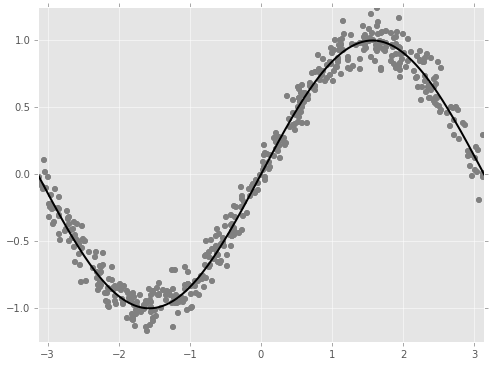

In [67]:
# Generate some data from a simple noiseless function
f = lambda x: np.sin(x)
x = np.linspace(-np.pi, np.pi, num=250)
y = f(x)

xs = rand.uniform(-np.pi, np.pi, N)
ys = f(xs) + rand.normal(0, 0.1, N)

def plot_truth():
    plt.plot(x, y, color = 'black')
    plt.xlim(-np.pi, np.pi); plt.ylim([-1.25, 1.25])
    
def plot_data():
    plt.plot(xs, ys, 'o', color='grey', markeredgewidth=0)
    
plot_data()
plot_truth()

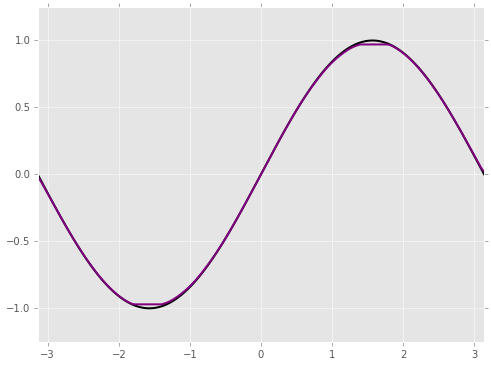

In [50]:
# Fit a gradient boosted regressor to this function and plot both the functiona and f

model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=500)
model.fit(to_column(x), y)

y_hat = model.predict(to_column(x))

plot_truth()
plt.plot(x, y_hat, color='purple')

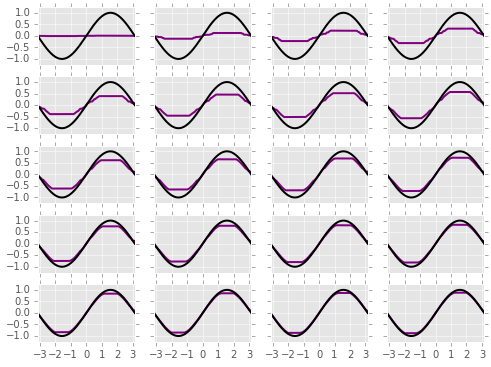

In [52]:
# Plot the partial sums of the weak learners to see what is going on.
# The point: the model learns gradually!

models = list(model.staged_predict(x.reshape(250, 1)))
fig, axes = plt.subplots(nrows=5, ncols=4, sharex=True, sharey=True)

for i, ax in enumerate(axes.flatten()):
    ax.plot(x, models[15*i], color="purple")
    ax.plot(x, y, color = 'black')
    plt.xlim(-np.pi, np.pi); plt.ylim([-1.25, 1.25])

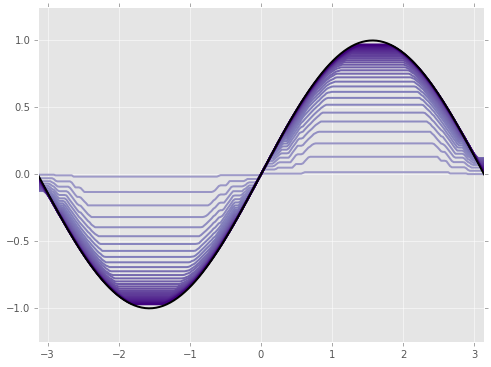

In [56]:
for i, pred in enumerate(model.staged_predict(to_column(x))):
    if i % 15 == 1:
        plt.plot(x, pred, color=plt.cm.Purples(float(i) / 1000 + 0.5), linewidth=2)
    
plot_truth()
        

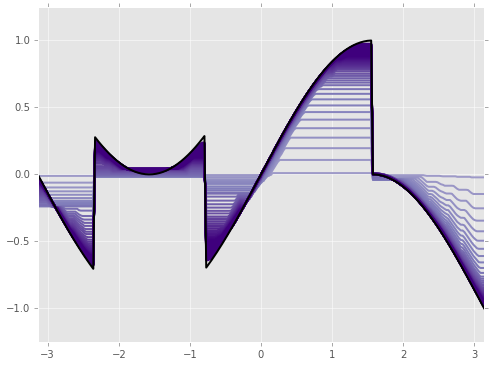

In [58]:
# Boosting can even handle complex, discontinuous loss functions

y_discontinuous = y + (x >= -0.75*np.pi)*(x <= -0.25*np.pi) - (x >= 0.5*np.pi)

def plot_discontinuous_truth():
    plt.plot(x, y_discontinuous, color = 'black')
    plt.xlim(-np.pi, np.pi); plt.ylim([-1.25, 1.25])
    
model = GradientBoostingRegressor(learning_rate=0.01, n_estimators=1000)
model.fit(to_column(x), y_discontinuous)
    
for i, pred in enumerate(model.staged_predict(to_column(x))):
    if i % 15 == 1:
        plt.plot(x, pred, color=plt.cm.Purples(float(i) / 1000 + 0.5), linewidth=2)
        
plot_discontinuous_truth()
        

In [ ]:
def plot_classification_boundary():
    x_cubic = linspace()

In [ ]:
Mention different implementations.